# Final Project: Analysis of GW190521

For this assignment, you will have to conduct an analysis of the gravitational-wave signal GW190521. This analysis should be done within a Jupyter notebook, with many comments in [Markdown](https://colab.research.google.com/notebooks/markdown_guide.ipynb) desribing and **justifying** the steps taken.

- The writing should be at the level of a fellow student of the class
- Submit **both** the .ipybn file and the converted .pdf file:
  - submit the .pdf file to TurnitIn (make sure all the cells have been run).
  - and the .ipynb file by e-mail with the subject "PXT903/PX4236 Final Project"
- Describe **in details** every step of your analysis throughout the notebook.
- Any setting choice (sampling rate, window parameter, FFT length, etc...) needs to be justified, either by its own investigation or relevant citations from the literature.
- Code alone, without a detailed descriptions of what is done and why, is worth half marks at the most.

NOTE: you can use any of the notebooks covered in the class, or code available online, _provided that you justify the settings and methods used_.

## Introduction (15 points)
Minimum 300 words.
- Write an introduction to this analysis, citing the relevant context and literature.
- Write a short summary of what is done in the notebook.

## The data and noise model (10 points)

- Download and plot the relevant gravitational-wave data for GW190521.
- Compute and plot the Power Spectrum Density.
- Compute and plot the whitened data. Use filters if necessary to best highlight where the signal is (or might be).

First I will import `pyplot` in order to visualise the data, and `numpy` to handle arrays. I also need the `gwpy` module to access `gwosc.datasets`, which is a tool that allows me to access data releases and GW catalogues such as GWTC-1. I will keep this in a seperate cell so it only has to be run once. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np

! pip install -q gwpy
from gwosc.datasets import event_gps

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


GW timing is described using GPS time. This is a measure of time in seconds which does not account for leap seconds, so is much better for continuous experiments like GW observing runs. To get the GPS time of the GW190521 (initially **S190521g**) we use the `event_gps` function. We can convert from GPS to calendar time using `from_gps`

In [2]:
from gwpy.time import from_gps

gps = event_gps('GW190521')

print(f"The GPS time is: {gps} seconds")
print(f"The calendar date is {from_gps(gps)}")

The GPS time is: 1242442967.4 seconds
The calendar date is 2019-05-21 03:02:29.400000


We can use the GPS time to retrieve the strain data for the event using `fetch_open_data`. We can get data for Livingston, Hanford and Virgo detectors. This might take a while so should only run once. I'm going to capture 64 seconds of data either side of the event gps time in order to ensure that I have contained the entire event. I will trim this down later to a more reasonable value once I have plotted the graphs.

In [3]:
from gwpy.timeseries import TimeSeries

segment_length = 64 #seconds
segment = (int(gps)-(segment_length/2), int(gps)+(segment_length/2))

ldata = TimeSeries.fetch_open_data('L1', *segment) #livingston
hdata = TimeSeries.fetch_open_data('H1', *segment) #hanford
vdata = TimeSeries.fetch_open_data('V1', *segment) #virgo

I can plot the data using pyplot, using the specific colours assigned to the GW observatories for clarity. The event occurs at the point marked by the dotted vertical line

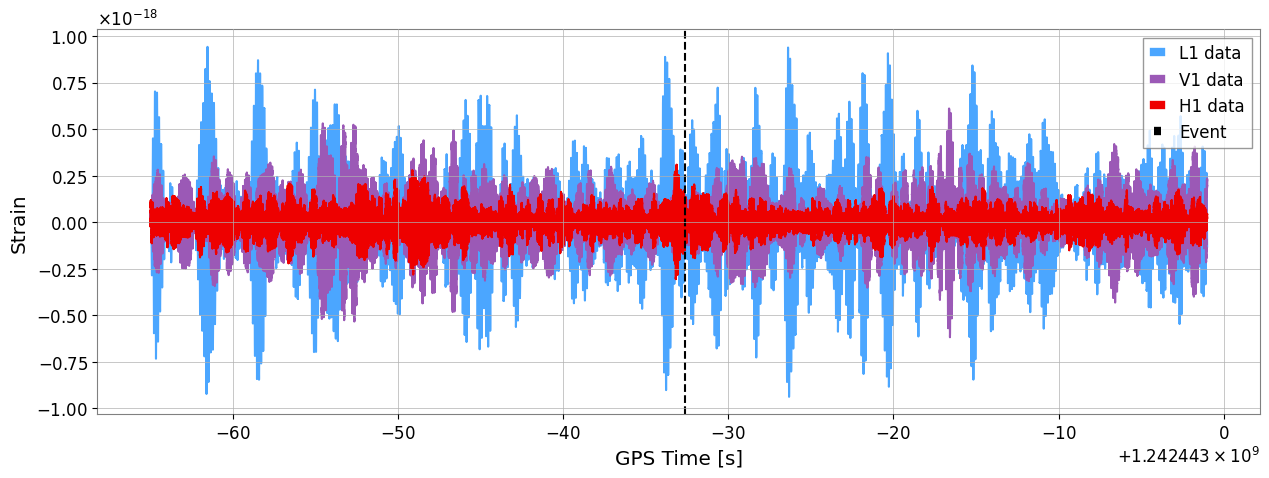

In [4]:
plt.figure(figsize=(15,5))
plt.plot(ldata.times,ldata,label='L1 data',color='gwpy:ligo-livingston')
plt.plot(vdata.times,vdata,label='V1 data',color='gwpy:virgo')
plt.plot(hdata.times,hdata,label='H1 data',color='gwpy:ligo-hanford')
plt.axvline(gps, linestyle="--", color='k', label="Event")
plt.xlabel('GPS Time [s]')
plt.ylabel('Strain')
plt.legend()
plt.show()

I will plot the spectral density of the whole segment. This is done using a fast fourier transform. It makes the assumption that the component frequencies present are time inveriant so it will give a rough noise profile of the three detectors. I will make a cutoff at anything below 10hz as there is not long enough data range in order to accurately assess these frequencies, and above 1khz as this is the maximum I can calculate based on the sample rate of the data. In order to mitigate edge effects, a window function needs to be applied. This slowly reduces the strain at the endes of the sample, to stop the fourier transform picking up on the harsh cutoff at the edge of the dataset. The window length is set to 2 as this is a good trade off between frequency resolution and power resolution.

[]

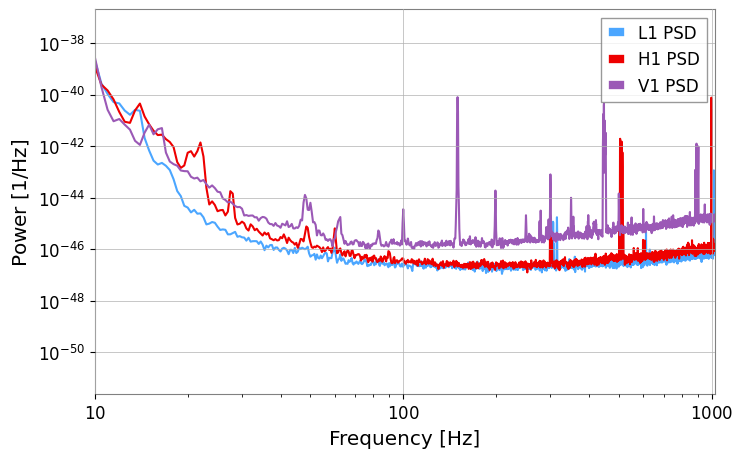

In [5]:
window_l = 2
lpsd=(ldata.psd(fftlength=window_l))
hpsd=(hdata.psd(fftlength=window_l))
vpsd=(vdata.psd(fftlength=window_l))

plt.figure(figsize=(8,5))
plt.loglog(lpsd.frequencies,lpsd,label='L1 PSD',color='gwpy:ligo-livingston')
plt.loglog(hpsd.frequencies,hpsd,label='H1 PSD',color='gwpy:ligo-hanford')
plt.loglog(vpsd.frequencies,vpsd,label='V1 PSD',color='gwpy:virgo')

plt.xlabel('Frequency [Hz]')
plt.ylabel('Power [$1/\mathrm{Hz}$]')
plt.xlim(10,1024)
plt.legend()
plt.plot()

Now I can apply whitening to the data in order to flatten out the predictable noise structure. THis uses the PSD to identify the underlying noise structure and then corrects for this. 

In [6]:
ldata_white = ldata.whiten(fftlength=window_l)
hdata_white = hdata.whiten(fftlength=window_l)
vdata_white = vdata.whiten(fftlength=window_l)

I can then bandpass the data using the built in `bandpass` function, which removes frequencies outside of the range we are interested in. From the psd graph above I choose a minimum of 50 hz, to remove the increase in noise at the low end. Knowing the length of a typical GW is in the order of magnitude of 1 second, I chose the upper limit of 120Hz, because any wave components above this are going to be oscillating 420 times in the 4 second segment i am going to select, too quickly to add detail to the graph.

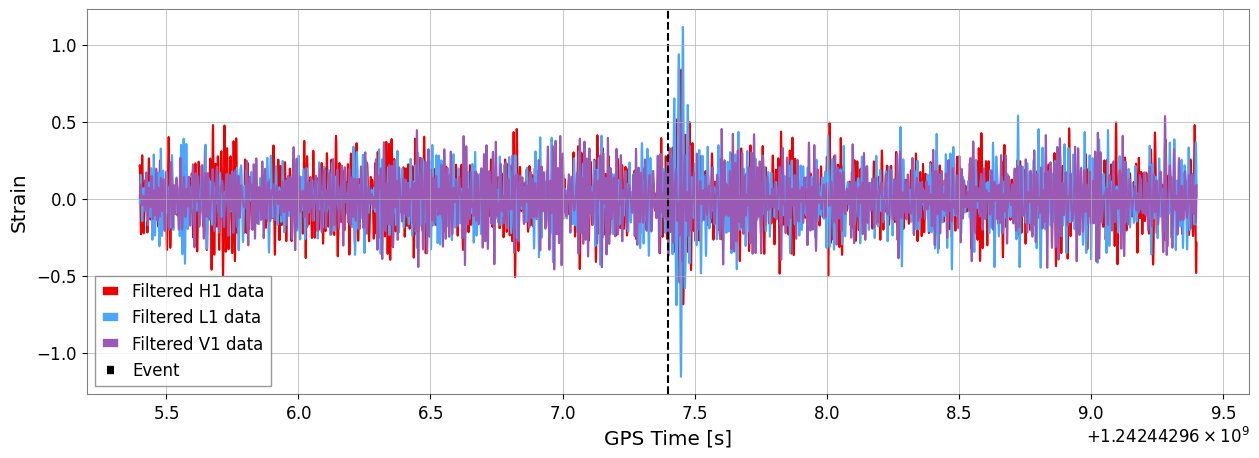

In [7]:
hdata_bp=hdata_white.bandpass(50,120).crop(gps-2,gps+2)
ldata_bp=ldata_white.bandpass(50,120).crop(gps-2,gps+2)
vdata_bp=vdata_white.bandpass(50,120).crop(gps-2,gps+2)

plt.figure(figsize=(15,5))
plt.plot(hdata_bp.times,hdata_bp,label='Filtered H1 data', color='gwpy:ligo-hanford')
plt.plot(ldata_bp.times,ldata_bp,label='Filtered L1 data', color='gwpy:ligo-livingston')
plt.plot(vdata_bp.times,vdata_bp,label='Filtered V1 data', color='gwpy:virgo')
plt.axvline(gps, linestyle="--", color='k', label="Event")
plt.xlabel('GPS Time [s]')
plt.ylabel('Strain')
plt.legend()
plt.show()

THis is a bit too much data, so lets zoom in around the event mark in order to get some more detail. I know there should be more inspiral data before the event, and after the event will return back to normal so lets take 0.3 seconds before and 0.2 seconds aftere the event GPS time

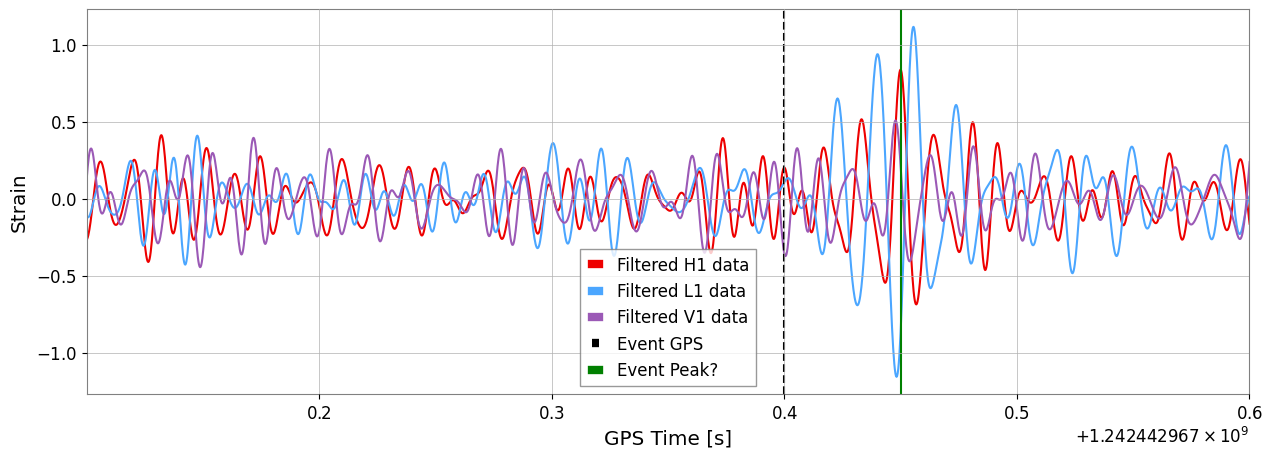

In [8]:
plt.figure(figsize=(15,5))
plt.plot(hdata_bp.times,hdata_bp,label='Filtered H1 data', color='gwpy:ligo-hanford')
plt.plot(ldata_bp.times,ldata_bp,label='Filtered L1 data', color='gwpy:ligo-livingston')
plt.plot(vdata_bp.times,vdata_bp,label='Filtered V1 data', color='gwpy:virgo')
plt.axvline(gps, linestyle="--", color='k', label="Event GPS")
plt.axvline(gps+0.05, linestyle="-", color='green', label="Event Peak?")
plt.xlabel('GPS Time [s]')
plt.ylabel('Strain')
plt.xlim(gps-0.3,gps+0.2)
plt.legend()

The reported GPS time (dashed) does not look like it is lining up with the event at this resolution, but the event is clearly visible at the green line. 

## The signal model (10 points)

- Generate and plot a CBC signal which you expect to be a good match for the signal. Use the literature, and cite your sources
- Generate and plot a phenomenological model (sometimes refer to as a "Burst" model). A model whose parameters describe the shape of the waveform itself, not the source. 
- Compute the overlap between those those two signals, and try to find parameters that maximises that overlap.

NOTE: remember that gravitational-wave are redshifted.

In order to generate a CBC signal we will use `pycbc` so first lets install it and import the required functions.


In [12]:
! pip install -q lalsuite pycbc
from pycbc.waveform import get_td_waveform

CBC assumes the source of the gravitational wave, so lets get some papers to back up the assumption that this was a binary merger event. I will draw data from two different papers by the LIGO collaboration, the first of which places constrains on the masses of the objects involved in the merger and the second of which constrains the redshift. 

redshift = 0.8

m1 = 85+21-14 M_sol

m2 = 66+17-18 M_sol

m remnant = 142+28-16 M_sol

f_0 = 11Hz

[Abbott 2020a]

redshift = 0.82+0.28-0.34

luminousity distance = 5.3+2.4-2.6 Gpc

[Abbott 2020b]

####Citations

Abbott, R., Abbott, T.D., Abraham, S., Acernese, F., Ackley, K., Adams, C., Adhikari, R.X., Adya, V.B., Affeldt, C., Agathos, M. and Agatsuma, K., 2020a. Properties and astrophysical implications of the 150 M⊙ binary black hole merger GW190521. The Astrophysical Journal Letters, 900(1), p.L13.

Abbott, R., Abbott, T.D., Abraham, S., Acernese, F., Ackley, K., Adams, C., Adhikari, R.X., Adya, V.B., Affeldt, C., Agathos, M. and Agatsuma, K., 2020b. GW190521: a binary black hole merger with a total mass of 150 M⊙. Physical review letters, 125(10), p.101102.

In [24]:
m1 = 85 # Solar masses
m2 = 66 # Solar masses
z = 0.82
f_0 = 11 #Hz

d = 2413.5 #Mpc (from redshift)

hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=m1,
                         mass2=m2,
                         distance=d,
                         delta_t=1./1024.,#timestep
                         f_lower=f_0)

Text(0.5, 0, 'Time (s)')

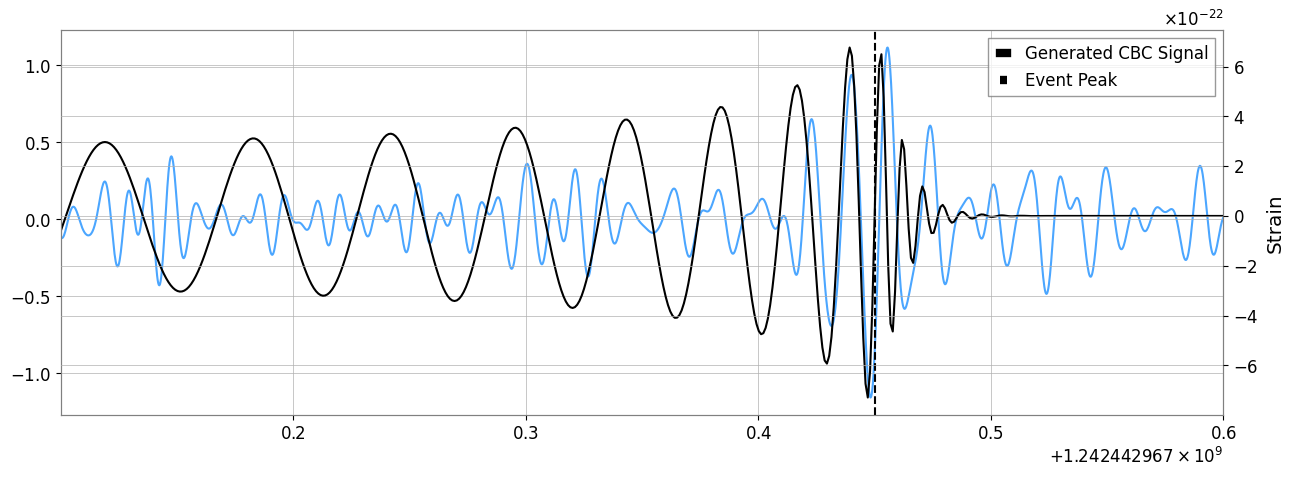

In [33]:
fig, ax1 = plt.subplots(figsize=(15,5))

ax2 = ax1.twinx()
ax1.plot(ldata_bp.times,ldata_bp,label='Filtered L1 data', color='gwpy:ligo-livingston')
ax2.plot(hp.sample_times+gps+0.05,hp,label='Generated CBC Signal', color='k')

plt.axvline(gps+0.05, linestyle="--", color='k', label="Event Peak")
plt.xlabel('GPS Time [s]')
plt.ylabel('Strain')
plt.xlim(gps-0.3,gps+0.2)
plt.legend()

plt.xlabel('Time (s)')

If I dont make assumptions about the source of the data, I can still attempt to generate a model for the data. I will do this by using a sin-gaussian signal.

Text(0.5, 0, 'Time (s)')

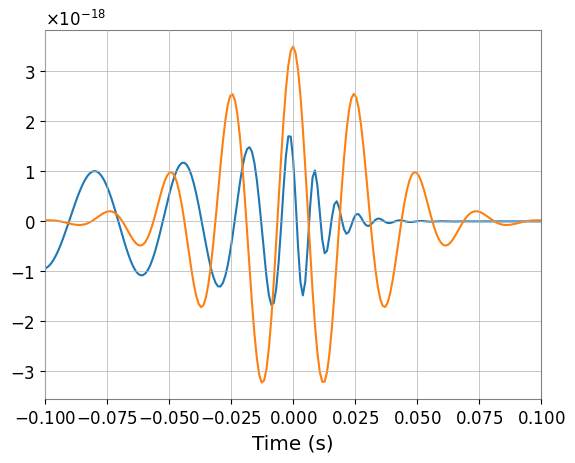

In [36]:
from scipy.signal import gausspulse

plt.plot(hp.sample_times, hp)
gp = gausspulse(hp.sample_times, fc=40, bw=0.3)*3.5e-18
plt.plot(hp.sample_times, gp)
plt.xlim(-0.1,0.1)

plt.xlabel('Time (s)')

In [35]:
fig, ax1 = plt.subplots(figsize=(15,5))

ax2 = ax1.twinx()
ax1.plot(ldata_bp.times,ldata_bp,label='Filtered L1 data', color='gwpy:ligo-livingston')
ax2.plot(hp.sample_times+gps+0.05,hp,label='Generated CBC Signal', color='k')

plt.axvline(gps+0.05, linestyle="--", color='k', label="Event Peak")
plt.xlabel('GPS Time [s]')
plt.ylabel('Strain')
plt.xlim(gps-0.3,gps+0.2)
plt.legend()

plt.xlabel('Time (s)')

## Detection (25 points)
Limiting yourself to a coincident (**not** coherent) analysis:
- Compute the SNR time series for the CBC signal model
- Compute the SNR time series for the Burst signal model
- Discuss the differences, if any.
- Estimate a bound on the False Alarm Rate of the detection.

## Parameter Estimation (25 points)
Moving to a **coherent** analysis:
- Using the CBC model, build a likelihood, prior and posterior function for the network of gravitational-wave detectors.
- Maximise that function and plot the relevant quantities.
- Interface that posterior function with a sampling algorithm (you are free to select any ready-made algorithm).
- Perform the sampling, and plot the results.
- Redo the steps above with the Burst model.
- Compare the results and discuss.

## Conclusions (15 points)
Minimum 300 words.
- Discuss your results in the context of the literature.
- Mention how your work compares with published results.
- Discuss some of the interpretation possibles of GW190521, including relevant citations from the literature, and summarising them.